# Исследование рынка общественного питания в Москве.
<a id="home"></a>

        Группа партнеров решила открыть кафе, визитной карточкой которого станет необычный персонал - роботы. 
        Перед открытием подобного заведения необходимо провести первичное исследование - определить тип будущего места 
    общественного питания, количество посадочных мест и оптимальную локацию.
        Для достижения поставленной цели была получена база данных (БД) с информацией с аналогичными параметрами уже 
    существующих заведений (название, адрес, количество посадочных мест).

1. [Подготовка данных.](#stage_1)
    * [Знакомство с данными.](#get_aquainted_with_the_data)
    * [Предобработка данных.](#changing_data)
    * [Вывод.](#summary_stage_1)
2. [Анализ данных.](#stage_2)
    * [Исследование видов кафе и ресторанов и сетевых общепитов.](#analysis_chain_rests)
        * [Промежуточный итог.](#summary_middle_2_1)
    * [Исследование количества посадочных мест.](#analysis_seats)
        * [Промежуточный итог.](#summary_middle_2_2)
    * [Исследование географии мест общественного питания.](#analysis_geography)
        * [Промежуточный итог.](#summary_middle_2_3)
3. [Рекомендации.](#stage_3)

## Этап 1: Подготовка данных. 
<a id="stage_1"></a>

#### Знакомство с данными
<a id="get_aquainted_with_the_data"></a>

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings 

warnings.simplefilter("ignore")

In [2]:
#import data
rests_df = pd.read_csv('/datasets/rest_data.csv')

In [3]:
##getting aquainted with dataset: 
print('----- rests_df -----')
print(rests_df.info())
print()
print(rests_df.columns)
print()
print(rests_df.head(2))
print()

----- rests_df -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB
None

Index(['id', 'object_name', 'chain', 'object_type', 'address', 'number'], dtype='object')

       id object_name chain object_type  \
0  151635     СМЕТАНА   нет        кафе   
1   77874      Родник   нет        кафе   

                                             address  number  
0         город Москва, улица Егора Абакумова, дом 9      48  
1  город Москва, улица Талалихина, дом 2/1, корпус 1      35  



In [4]:
#checking for N/A values:
print('Количество пропусков в столбцах')
print(rests_df.isnull().sum())

Количество пропусков в столбцах
id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64


In [5]:
#checking for duplicates:
print('Число полных дубликатов',rests_df.duplicated().sum())

Число полных дубликатов 0


        Было проведено первичное знакомство с данными. На данном этапе не было обнаружено аномалий: данные загружены 
    корректно, пропусков и полных дубликатов нет.
        Стоит обратить внимание на столбцы с нечисловыми данными и категоральными переменными: 'object_name', 'chain', 
    'object_type'. В этих столбцах возможно наличие опечаток, которые могут привести к искажениям результатов анализа. 
    Следовательно потребуется дополнительно проверить значения этих столбцов.
        Столбец 'address' также не является количественным, для исследования дополнительной проверки не требуется - из 
    адреса возьмем только название улицы.

#### Предобработка данных
<a id="changing_data"></a>

In [6]:
#exaxmining unique values:
print("Число уникальных значений до изменения регистра",len(rests_df['object_name'].unique()))
# adding new column with lower case letters:
rests_df['object_name_lc'] = rests_df['object_name'].str.lower() 
print('-----------------------------------------------')
print("Число уникальных значений после изменения регистра", len(rests_df['object_name_lc'].unique()))

Число уникальных значений до изменения регистра 10393
-----------------------------------------------
Число уникальных значений после изменения регистра 9924


        На первый взгляд, дополнительная обработка данных не требуется, т.к. при первичном ознакомлений с данными никаких 
    проблем выявлено не было. Однако дополнительно стоит проверить нечисловые столбцы, в частности, 'object_name'
        Как видно, при изменении регистра, число уникальных значений уменьшилось. Из этого можно сделать следующие 
    предположения:
    1) При заполнении таблицы были допущены некритичные ошибки, связанные с несоблюдением регистра в официальном названии заведения. В этом случае, мы нашли ошибку, возможно у нас появятся дублирующие записи.
    2) Есть вероятность, что изменение числа уникальных названий изменилось, т.к. есть заведения с идентичными названиями, но отличающиеся по способу их написания. В этом случае, удалять их не стоит.
        Чтобы не стирать лишние записи, проведем удаление дубликатов при совпадении двух столбцов -  'object_name' и 
    'address'.
    


In [7]:
#deleting the dublicates:
rests_df = rests_df.drop_duplicates(subset = ['object_name_lc', 'address']).reset_index(drop = True)
print('Количество наблюдений в БД',rests_df.shape[0])

Количество наблюдений в БД 15141


        В итоге, чуть больше 150-ти значений дублировали друг друга.
        Исследуем столбец 'chain'. Убедимся, что значения в солбце строго заданы.

In [8]:
#examining 'chain'
print(rests_df['chain'].value_counts())

нет    12204
да      2937
Name: chain, dtype: int64


        Переменные принимают только два значения.

        Теперь обратим внимание на столбец object_type. Выведем уникальные значения и выясним, можно ли их как-то 
    оптимизировать.

In [9]:
print(rests_df['object_type'].value_counts())

кафе                                 5991
столовая                             2572
ресторан                             2271
предприятие быстрого обслуживания    1885
бар                                   849
буфет                                 565
кафетерий                             392
закусочная                            344
магазин (отдел кулинарии)             272
Name: object_type, dtype: int64


        Этот столбец содержит в целом односложные типы заведений общественного питания. Однако присутствуют и "громоздкие" 
    типы, а именно - "предприятие быстрого обслуживания" и "магазин (отдел кулинарии)". Чтобы такие длинные названия не 
    портили красоту будущих графиков, заменим значения на "фастфуд" и "кулинария" соответственно.

In [10]:
#changing column values "предприятие быстрого обслуживания" & "магазин (отдел кулинарии)":
rests_df['object_type'] = rests_df['object_type'].replace('предприятие быстрого обслуживания', 'фастфуд')
rests_df['object_type'] = rests_df['object_type'].replace('магазин (отдел кулинарии)', 'кулинария')
#check
#print(rests_df['object_type'].value_counts())

        Мы успешно изменили некоторые названия строк в данном столбце.

## Вывод
<a id="summary_stage_1"></a>

        Данные загружаются хорошо, пробелов нет, однако в отдельных случаях может нарушаться регистр. БД готова для 
    дальнейшего исследования.

[К оглавлению](#home)

## Этап 2: Анализ данных. 
<a id="stage_2"></a>

#### Исследование видов кафе и ресторанов и сетевых общепитов
<a id="analysis_chain_rests"></a>

        Сперва можно исследовать распределение ресторанов по видам. Наиболее наглядно это будет выглядеть на графике.

In [11]:
# setting plot style and pallete
plt.style.use('bmh')
sb.set_palette('BuGn_r', n_colors=10)

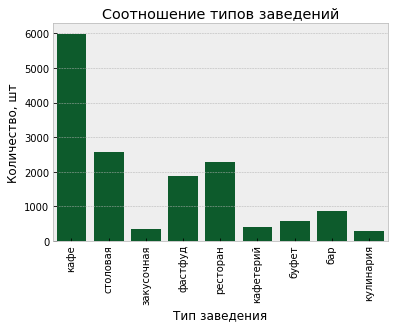

In [12]:
# making a plot
sb.countplot(x='object_type', data=rests_df, color='#00682a')
plt.xticks(rotation=90)
# plt.legend()
plt.title("Соотношение типов заведений")
plt.xlabel("Тип заведения")
plt.ylabel("Количество, шт")
plt.show()

In [13]:
rests_df['object_type'].value_counts()

кафе          5991
столовая      2572
ресторан      2271
фастфуд       1885
бар            849
буфет          565
кафетерий      392
закусочная     344
кулинария      272
Name: object_type, dtype: int64

        Структурированные данные можно разбить на несколько категорий:
        1) Явное большинство заведений являются кафе.
        2) На втором месте можно разместить несколько мест общепита: столовая, ресторан, фастфуд
        3) Наименее многочисленными являются бары, буфеты, кафетерии, закусочные и кулинарии.
        Можно ли сделать какие-то выводы, исходя из этих данных? Во-первых, необходимо понять, какие различия у кафе с 
    остальными видами общепита, как присваивается данная категория.
        В соответствии с информацией, взятой из свободного источника (https://kr-gazeta.ru/obshchestvo/edim_ne_doma_chem_otlichayutsya_stolovaya_kafe_bar_restoran/), кафе имеют меньшее и более простое 
    меню, т.е. основные ограничения накладываются на кухню. Таким образом, это более универсальный общепит с ресторанной       атмосферой. Возможно именно простота и оптимизация расходов (не нужен шеф-повар из Италии и изысканные блюда) и делают 
    кафе столь многочисленными.
        Популярность второй группы заведений обуславливается, с одной стороны, универсальностью, а с другой - 
    необходимостью: ритм жизни и уровень дохода склоняют людей к фастфудам, а столовые, зачастую находящиеся в бизнес-
    центрах (БЦ) стали неотъемлемой частью жизни многих сотрудников офисов.

        Развивая данную тему, можно выдвинуть гипотезу о том, что большинство кафе, в силу ввоей простоты, являются 
    сетевыми. 

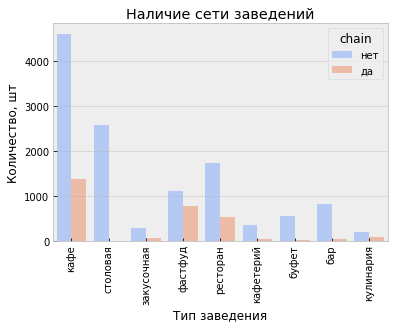

In [14]:
# making a plot, examine restaurant chains:
sb.countplot(x='object_type', hue='chain', data=rests_df, palette ='coolwarm')
plt.xticks(rotation=90)
# plt.legend()
plt.title("Наличие сети заведений")
plt.xlabel("Тип заведения")
plt.ylabel("Количество, шт")
plt.show()

In [15]:
# making pivot table of restaurant chains:
rests_object_type_pivot = rests_df.pivot_table(index='object_type',columns='chain',values='object_name',aggfunc='count')
rests_object_type_pivot = rests_object_type_pivot.reset_index()
rests_object_type_pivot['ratio'] = (rests_object_type_pivot['да'] / 
                                    (rests_object_type_pivot['да'] + rests_object_type_pivot['нет']))
#print(rests_object_type_pivot)
rests_object_type_pivot['ratio'] = rests_object_type_pivot['ratio'] * 100

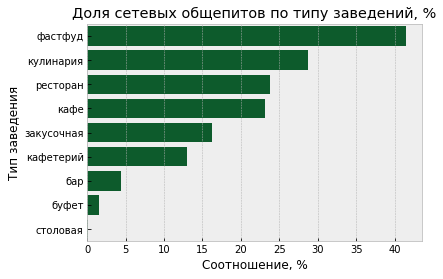

In [16]:
sb.barplot(x='ratio',y='object_type',data=rests_object_type_pivot.sort_values(by='ratio',ascending=False), color='#00682a')
# plt.xticks(rotation=90)
# plt.legend()
plt.title("Доля сетевых общепитов по типу заведений, %")
plt.xlabel("Соотношение, %")
plt.ylabel("Тип заведения")
plt.show()

        Продолжая исследование было построено два графика. На первым сравнивались абсолютные показатели по числе сетевых и 
    несетевых заведений в каждой категории. Глядя на этот график видно, что большинство сетевых заведений Москвы являются 
    кафе.
        Тем не менее, стоит проверить, соотношение числа сетевых и несетевых заведений для формирования полной картины. 
    Второй график как раз показывает, что фастфуд это по большей части сетевой бизнес.За ним идет кулинария, а далее - кафе 
    и рестораны.

#### Вывод
<a id="summary_middle_2_1"></a>

        После первой части анализа было установлено следующее:
        1) Чаще всего в Москве открываются кафе, число сетевых заведений этого типа наибольшее. Было выдвинуто 
    предположение о том, что заведения такого типа более гибкие и "экономичные" с точки зрения владельца.
        2) Фастфуд является сетевым бизнесом, доля сетевых заведений такого типа превышает 40%.От 20% до 30% пунктов 
    общественного питания типа ресторана, кулинарии и кафе являются сетевыми.

[К оглавлению](#home)

#### Исследование количества посадочных мест
<a id="analysis_seats"></a>

        Следующим этапом исследования станет изучение характерного числа посадочных мест для каждого типа объектов 
    общественного питания. 

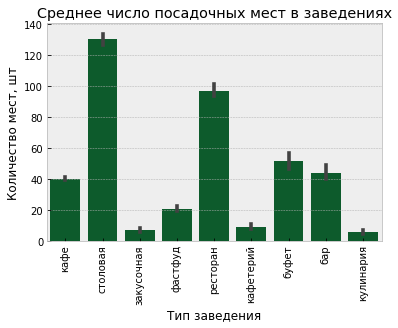

In [17]:
#bar chart for average seats per object type:
sb.barplot(x='object_type',y='number', data=rests_df,color='#00682a')
plt.xticks(rotation=90)
# plt.legend()
plt.title("Среднее число посадочных мест в заведениях")
plt.xlabel("Тип заведения")
plt.ylabel("Количество мест, шт")
plt.show()

        Итак, большое количетво посадочных мест характерно для столовых. Это логично, поскольку, как правило, такие 
    заведения открываются с расчетом на большой поток клиентов. 
        Буфеты и рестораны также устанавливают большое количество посадочных мест. Буфеты действуют по аналогии со 
    столовыми. Рестораны же - многопрофильное заведение, в котором могут проводиться, например, банкеты или свадьбы. 
    Следовательно, наличие большого количества посадочных мест в ресторане может быть его дополнительным преимуществом.

        Далее будут подробнее исследовано распределение сетевых заведений. Из данных необходимо выделить только сетевые 
    места и проанализировать распределение мест в заведениях и количество ресторанов в сети.

In [18]:
#making data slice on chain rests:
rests_chain_true = rests_df.loc[rests_df['chain'] == 'да'].copy()

In [19]:
#preparing a table with uique rests names:
rests_chain_true_grouped = (rests_chain_true.groupby('object_name_lc', as_index=False)
                            .agg({'address':'count','number':'mean'}))
rests_chain_true_grouped.columns = ['object_name_lc','object_count','seats']

count    576.000000
mean       5.098958
std       15.327915
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max      154.000000
Name: object_count, dtype: float64




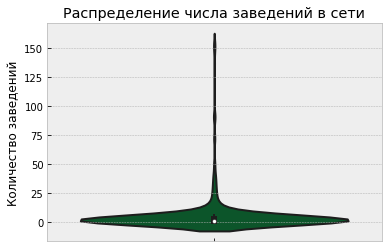

In [20]:
#checking the distribution of values:
print(rests_chain_true_grouped['object_count'].describe())
print()
print()
#violin plot:
sb.violinplot(y='object_count',data=rests_chain_true_grouped)
# plt.xticks(rotation=90)
# plt.legend()
plt.title("Распределение числа заведений в сети")
# plt.xlabel("Тип заведения")
plt.ylabel("Количество заведений")
plt.show()

        Для каждого сетевого места общественного питания было подсчитано количество заведений и визуализировано 
    распределение величин. 
        Количество ресторанов в сети сильно дифференцировано: значения варьируются от 1 до 154 заведений в сети. Значение 1 
    - явная ошибка, свидетельствующая о неправильной записи названий ресторанов и/или категории "сетевой".75% значений не 
    превышают 3 ресторанов.
        Чтобы исследование распределения было максимально достоверным, разобьем заведения на категории по количеству 
    ресторанов в сети:
    1)малые. Сетевые рестораны с количеством отделений от 2 до 5
    2)средние. Сетевые рестораны с количеством отделений от 6 до 20
    3)средние+. Сетевые рестораны с количеством отделений от 21 до 50
    4)большие. Сетевые рестораны с количеством отделений от 51 до 75
    5)большие+. Сетевые рестораны с количеством отделений от 76
        Если в сети меньше двух ресторанов - удаляем.


In [21]:
#deleting all non-chain rests:
rests_chain_true_grouped = rests_chain_true_grouped.loc[rests_chain_true_grouped['object_count'] > 1].copy()

In [22]:
#creating a function for additional categorization:
def true_chain(number):
    if number >= 2 and number <= 5:
        return 'малые'
    if number > 5 and number <= 20:
        return 'средние'
    if number > 20 and number <= 50:
        return 'средние+'
    if number > 50 and number <= 75:
        return 'большие'
    if number > 75:
        return 'большие+'
rests_chain_true_grouped['chain_filter'] = rests_chain_true_grouped['object_count'].apply(true_chain)

        Новый столбец был доавлен. Теперь можно провести сравнение количества посадочных мест в общепитах для каждой 
    категории.

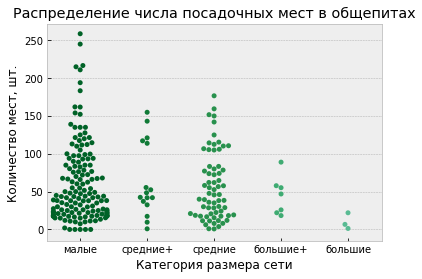

In [23]:
#swarmplot for number of seats:
sb.swarmplot(x='chain_filter',y='seats',data=rests_chain_true_grouped)
# plt.xticks(rotation=90)
# plt.legend()
plt.title("Распределение числа посадочных мест в общепитах")
plt.xlabel("Категория размера сети")
plt.ylabel("Количество мест, шт.")
plt.show()

        На первом графике визуально видно, что для малых и средних сетевых общепитов максимальное число посадочных мест 
    редко превышает 150. С увеличением охвата сети падает среднее максимальное количество посадочных мест для одной сети. 
    Следовательно, можно сделать вывод о том, что с развитием сети основатели перестают делать акцент на максимальном 
    количестве посадочных мест в помещении.
        Также стоит обратить внимание на плотность точек. Почти для каждой категории большое количество значений лежит в 
    промежутке 25-50 посадочных мест. визуализируем моду для каждой категории.

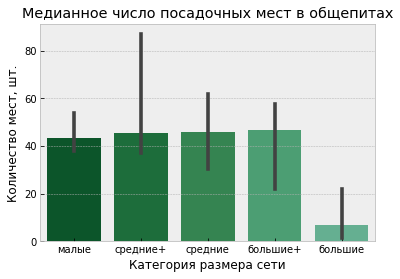

In [24]:
#count average seats per category
from numpy import median
sb.barplot(y='seats',x='chain_filter', data=rests_chain_true_grouped,estimator = median)
# plt.xticks(rotation=90)
# plt.legend()
plt.title("Медианное число посадочных мест в общепитах")
plt.xlabel("Категория размера сети")
plt.ylabel("Количество мест, шт.")
plt.show()

        Столбчатая диаграмма, отображающая моду каждой категории говорит о том, что половина всех заведений имеет не больше 
    45 посадочных мест.
        Тени на диаграмме говорят нам о выбросах в сторону уменьшения моды при увеличении размера сети.
        Два графика дают достаточно информации, чтобы сформулировать вывод о количестве посадочных мест в различных типах 
    заведений общественного питания.

#### Вывод
<a id="summary_middle_2_2"></a>

        1) Наибольшее количество посадочных мест присутствует, как правило, в столовых, ресторанах и буфетах. Это связано со специфическими задачами, которые должны выполнять данные заведения.
        2)Половина всех сетевых общепитов имеет не более 45 посадочных мест, при этом для крупных сетей характерно меньшее количество мест для посетителей, чем для средних и небольших

[К оглавлению](#home)

#### Исследование географии мест общественного питания
<a id="analysis_geography"></a>

        Для проведения анализа географии размещения мест общественного питания, необходимо выделить название улицы из 
    адреса.

        В БД присутствует ряд аномалий, например, записи "город Зеленоград" и "поселение Сосенское". Причина этих аномалий 
    заключается в методике записи адресов.
        Что касается Зеленограда, строки с адресом выглядят следующим образом: "город Москва, город Зеленоград, корпус 
    438", где "корпус 438", по сути является указанием на район (микрорайон 4) и номер дома (38). Т.е. как такового 
    названия улиц для подобных адресов нет. По этой причине, используем максимально близкую аналогию - номер корпуса. Во-
    первых, по номеру корпуса в Яндекс.Картах определяется местоположение, а во-вторых, в Зеленограде есть улицы с 
    привычными для нас названиями и нельзя просто заменить все названия улиц на Зеленоград.
        Относительно поселения Сосенское, ситуация обстоит сложнее. Помимо названия поселения есть название поселка, в 
    некоторых случаях вместо него название деревни. Запишем код для отбора улиц с учетом особенностей этих и других 
    подобных населенных пунктов. 

In [25]:
pattern = '\,(([а-яА-Я0-9\-ё\s"]+)?(улица|переулок|шоссе|проспект|аллея|проезд|набережная|площадь|тупик|переулок|луч|вал|бульвар|линия|квартал|километр|территория|микрорайон|деревня|корпус|просек|посёлок|село|Проезд)([а-яА-Яё0-9\-\s"]+)?)'
rests_df['true_street'] = rests_df['address'].str.extract(pat = pattern)[0]

In [26]:
rests_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15141 entries, 0 to 15140
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              15141 non-null  int64 
 1   object_name     15141 non-null  object
 2   chain           15141 non-null  object
 3   object_type     15141 non-null  object
 4   address         15141 non-null  object
 5   number          15141 non-null  int64 
 6   object_name_lc  15141 non-null  object
 7   true_street     15080 non-null  object
dtypes: int64(2), object(6)
memory usage: 946.4+ KB


In [27]:
rests_df['true_street'] = rests_df['true_street'].str.lstrip(' ')

        Получилось корректно выделить названия улиц.

        Продолжая дополнять основную БД, добавим информацию из статистики Мосгаза. Эти данные содержат все улицы, которые 
    пригодятся в работе, статистика, таким образом, будет точнее. Из столбцов таблицы нам понадобятся данные об улице и ее 
    принадлежности к району и округу.
        Загрузим БД и произведем слияние.

In [28]:
#loading new dataset
path = 'C://Users//Acer//Documents//Учеба//Аналитика данных//Аналитик данных//007. Рассказать историю с помощью данных//007. Проект//'
geo_df=pd.read_excel(path + 'mosgaz-streets.xls')

In [29]:
#getting aquainted with the data:
print(geo_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   streetname  4398 non-null   object
 1   areaid      4398 non-null   int64 
 2   okrug       4398 non-null   object
 3   area        4398 non-null   object
dtypes: int64(1), object(3)
memory usage: 137.6+ KB
None


In [30]:
# preparing geo_data for merging
del geo_df['areaid']
geo_df.columns = ['true_street','okrug','district']

        Одна и та же улица может принадлежать разным районам и округам. В работе необходимо однозначно закрепить 
    определенный район за определенной улицей. Следовательно, в будущем можно использовать первое вхождение как критерий 
    отбора.

In [31]:
print(len(geo_df['true_street'].value_counts()))
print(len(rests_df['true_street'].value_counts()))

3604
2079


        Итак, в таблице более 3,5 тыс. улиц, а уникальных значений улиц в исходной БД около 2 тыс. Мы можем сделать вывод, 
    что при слиянии бОльшая часть улиц получит значение округа и района, а расхождения будут минимальны.

        Теперь можно продолжить исследование. Составим ТОП-10 улиц по количеству мест общественного питания.

In [32]:
#making top_list
rests_df_top = (rests_df.groupby('true_street', as_index=False)
                .agg({'number':'mean','address':'count'})
                )
rests_df_top.columns = ['true_street','number','count']
rests_df_top = rests_df_top.sort_values(by='count',ascending=False)

In [33]:

#saving the namemes of the streets
top_10 = rests_df_top['true_street'].head(10).unique()

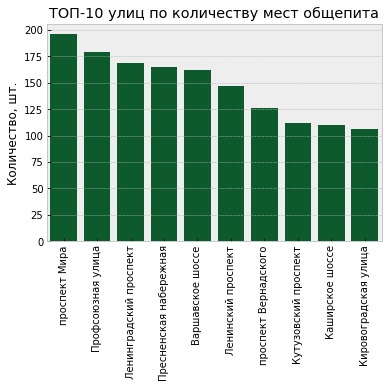

In [34]:
#making bar chart on rests_df_top_10:
(sb.barplot(y='count',x='true_street', 
            data=rests_df_top.head(10),
            color='#00682a'))
plt.xticks(rotation=90)
# plt.legend()
plt.title("ТОП-10 улиц по количеству мест общепита")
plt.xlabel("")
plt.ylabel("Количество, шт.")
plt.show()

        Итак, ТОП-10 улиц по коичеству мест общественного писания был построен. Лидером является проспект Мира.
        Большинство улиц находятся в пределах МКАД.
        Теперь посмотрим распределение мест общественного питания по районам и округам. Сначала необходимо загрузить и 
    обработать данные.

In [35]:
# merging rests_df_top & geo_df
rests_df_top = rests_df_top.merge(geo_df,on='true_street',how='outer')
# making disrtict top
rests_df_top_slice = rests_df_top.loc[rests_df_top['true_street'].isin(top_10)]
district_top = rests_df_top_slice['district'].value_counts()
print('Районы, в которых размещены улицы из ТОП-10')
print()
district_top

Районы, в которых размещены улицы из ТОП-10



Район Нагатино-Садовники           2
Район Тропарево-Никулино           2
Ломоносовский район                2
Район Теплый Стан                  2
Район Гагаринский                  2
Район Чертаново Северное           2
Район Чертаново Центральное        2
Обручевский район                  2
Донской район                      2
Район Чертаново Южное              2
Район Проспект Вернадского         2
Район Южное Бутово                 1
Академический район                1
Район Ростокино                    1
Пресненский район                  1
Ярославский Район                  1
Район Ясенево                      1
Район Сокол                        1
Район Раменки                      1
Район Северное Бутово              1
Нагорный район                     1
Район Коньково                     1
Останкинский район                 1
Район Беговой                      1
Район Марьина роща                 1
Район Орехово-Борисово Южное       1
Хорошевский район                  1
М

        В данной ситуации табличный вывод будет более наглядным. За редким исключением, улица с наибольшим количеством 
    заведений встречается в том или ином районе только один раз. Это может говорить о неравномерности распределения мест 
    общественного питания, и о некоторой "специализации" отдельных улиц.
        Исследуем, в каких округах расположены улицы из ТОП-10.

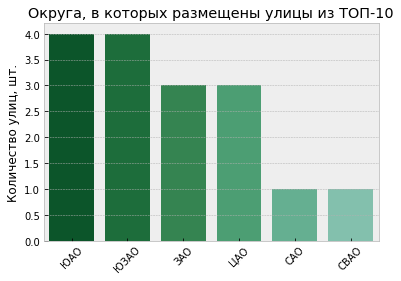

In [36]:
# making okrug top
okrug_top = (rests_df_top_slice.groupby('okrug',as_index=False)
             .agg({'true_street': pd.Series.nunique})
             .sort_values(by='true_street',ascending=False))
okrug_top.columns = ['okrug','count']
#creating rating for column 'okrug'
sb.barplot(x='okrug',y='count', data=okrug_top)
plt.xticks(rotation=45)
# plt.legend()
plt.title("Округа, в которых размещены улицы из ТОП-10")
plt.xlabel("")
plt.ylabel("Количество улиц, шт.")
plt.show()

        Исходя из графиков, больше всего мест общественного питания из нашего ТОП-10 расположено на проспекте Мира. 
    Второе место занимает Профсоюзная, а замыкает тройку Ленинградский проспект. 
        Причин распределения в целом может быть несколько, однако, скорее всего, это связано с размерами самой улицы, с 
    размещением БЦ (их достаточно на этих улицах), деловой активностью, а также количеством туристических мест.
    Относительно исследования по округам, наиболее заполненными являются Южный и Юго-Западный. В остальных же будет легче выбрать оптимальное место для размещения кафе.

        Узнаем распределение количества посадочных мест на улицах с большим количеством мест питания.
        Поскольку мы изучаем улицы с большим количеством мест общественного питания, дополнительно исключим совсем 
     небольшие значения.

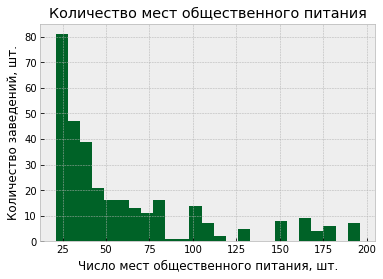

In [37]:
# getting aquainted with the distribution of values in count:
rests_street_seat = rests_df_top.loc[rests_df_top['count']>20].copy()
plt.hist(rests_street_seat['count'],bins=25)
# plt.xticks(rotation=45)
# plt.legend()
plt.title("Количество мест общественного питания")
plt.xlabel("Число мест общественного питания, шт.")
plt.ylabel("Количество заведений, шт.")
plt.show()

        На графике видно, что на большей части улиц количество заведений не превышает 50. Если построить распределение по 
    этим данным, оно получится неравномерным, характер зависимости двух пластов данных будет отличаться. Поэтому 
    распределение будет построено по улицам с количеством мест общественного питания больше 70 шт.

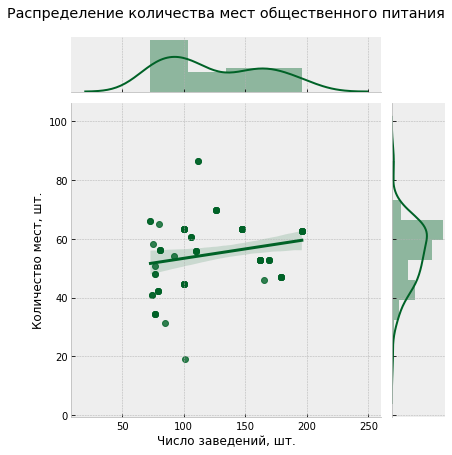

In [38]:
rests_street_seat_70 = rests_street_seat[rests_street_seat['count']>70].copy()
sb.jointplot(x="count", y="number", data=rests_street_seat_70, kind='reg')
# plt.xticks(rotation=45)
# plt.legend()
plt.title("Распределение количества мест общественного питания", pad=85)
plt.xlabel("Число заведений, шт.")
plt.ylabel("Количество мест, шт.")
plt.show()

        Из-за разницы распределения величин, зависимость получилась не совсем очевидной. Тем не 
    менее, мы видим, что на улицах с большим количеством заведений среднее число посадочных мест в одном заведении выше, 
    т.е. зависимость прямая.

        Аналогично исследуем улицы с одним  объектом общественного питания. Узнаем их количество и районы, в которых они 
    расположены.

In [39]:
# find out how many streets with only one catering place:
rests_df_anti_top = rests_df_top.loc[rests_df_top['count']==1].copy()
print('Число улиц с одним объектом общественного питания: ',len(rests_df_anti_top['true_street']))
print('Число районов с одним объектом общественного питания: ',len(rests_df_anti_top['district'].value_counts()))

Число улиц с одним объектом общественного питания:  721
Число районов с одним объектом общественного питания:  101


        721 улиц имеют только один объект общественного питания. Можно предположить, что причина в длине улицы, или сильной 
    удаленности от центров досуга, бизнеса, мест скопления туристов и т.д. Что касается числа районов, их 101. 
        Определим, в каких районах они расположены.

In [40]:
district_anti_top = rests_df_anti_top['district'].value_counts().reset_index()
district_anti_top.columns = ['district','count']

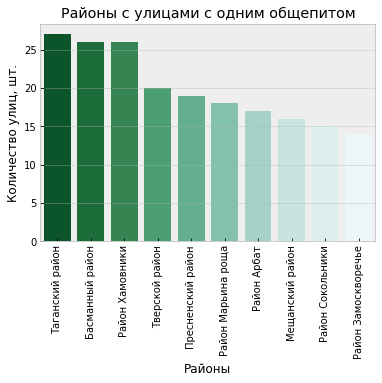

In [41]:
sb.barplot(x="district",y='count', data=district_anti_top.head(10))
plt.xticks(rotation=90)
# plt.legend()
plt.title("Районы с улицами с одним общепитом")
plt.xlabel("Районы")
plt.ylabel("Количество улиц, шт.")
plt.show()

        Исходя из полученного антирейтинга, можно сказать, что для 10 районов с наибольшим количеством улиц, где число мест 
    питания равно 1, характерен, скорее небольшой размер улиц (из всех вышеперечисленных гипотез). Отчасти это подтверждается тем, что районы расположены в основном в "старой" Москве с плотной застройкой и короткими улицами.

#### Вывод
<a id="summary_middle_2_3"></a>

        Ниже будут перечислены выводы относительно географии размещения мест общественного питания.
        1) Улицы с самым большим количеством мест общественного питания в основном расположены в пределах МКАД.
        2) Исходя из графиков, больше всего мест общественного питания расположено на Проспекте Мира - около 200. За редким 
    исключением, улица с наибольшим количеством заведений встречается в том или ином районе только один раз. Это может 
    говорить о неравномерности распределения мест общественного питания, и о некоторой "специализации" отдельных улиц.
        3) Как правило, для улиц с высокой плотностью общепитов, число посадочных мест у последних не превышает 50.
        4) Распределение количества посадочных мест на улицах с рекордным количеством заведений показывает слабую 
    положительную зависимость между средним числом мест и количеством заведений на определенной улице.

[К оглавлению](#home)

## Этап 3: Рекомендации. 
<a id="stage_3"></a>

        Рекомендации относительно подготовки данных:
        Необходимо более четкое структурирование заведений по типам. Помимо этого требуется унификация названий. Есть 
    ошибки в адресах: их тоже необходимо унифицировать. 
        Рекомендации относительно нового заведения:
        1) Тип заведения. Наибольшую адаптивность, гибкость имеют кафе. Их доля в сетевых общепитах и общая доля среди всех 
    остальных мест общественного питания показывает, что такой тип заведений в фаворе у владельцев. Поскольку главной 
    особенностью нашего будущего заведения будут роботы вместо официантов, кухня отходит на второй план, следовательно, 
    кафе станет наиболее оптимальным вариантом.
        2) Количество посадочных мест. В соответствии с результатами проведенного исследования, число посадочных мест в 
    будущем кафе не должно превышать 45. Однако для более подробного ответа на этот вопрос необходимо рассчитать экономику 
    одного посетителя.Чаще всего в Москве открываются кафе, число сетевых заведений этого типа наибольшее. Было выдвинуто 
    предположение о том, что заведения такого типа более гибки Это позволит спрогнозировать окупаемость и оптимальное 
    количество посетителей в день (следовательно и минимальное число посадочных) для получения прибыли с бизнеса.
        3) География расположения. Ресторан должен быть расположен в пределах МКАД. Округ, в целом, не имеет значения, 
    однако, лучше воздержаться от открытия кафе в ЮЗАО и ЮАО из-за повышенной плотности мест общественного питания. В 
    качестве предложения можно рассмотреть ЗАО, СЗАО или ЦАО. В продолжение рекомендации, может подойти место близ района 
    Дорогомилово. В силу хорошей транспортной доступности, почти из любого места в центре можно туда попасть. В силу 
    специфики будущего заведения предлагается рассмотреть его размещение вблизи технических вузов, мест, связанных с 
    технологиями и робототехникой.
        Предположения о развитии сети.
        Как говорилось в п.3, рестораны можно открывать рядом с техническими вузами и местами, посвященными технологиям и 
    робототехнике. В таком случае, роботы могут даже стать частью выставки и будут "к месту". Риск состоит в том, что таких 
    заведений мало, а места, обеспечивающие приток посетителей могут закрыться.
      

[К оглавлению](#home)